## A brief notebook to answer the question:
# "Which job title am I actually doing in my current position"
### <i>A quick data exploration of: </i> <b>Data Scientist vs. Software Engineer</b> 

2018-01
Justin Gosses

---------------------------------------

## Background
Who is a data scientist isn't exactly an easy question to answer. There are multiple reasons for this. Partly, the confusion comes from the fact that the position hasn't existed, at least in its current form, until quite recently.  Managers may not have employed one before and more and more people want to be one. <a href="https://hbr.org/2012/10/data-scientist-the-sexiest-job-of-the-21st-century">Sexiest job of the 21st century</a> and all that malarkey. Additionally, like many jobs, responsibilities vary depending on the size and type of employer. Responsbilities may or may not be divided up between data scientistis, software engineers, data engineers, data visualization engineers, data analysts, etc.

## Premise
<b>One source of truth for who is a data scientist is the people hiring data scientists.</b> Of course, there is an argument made against this approach, especially as many of them might be hiring data scientists for the first time. However, they've been helpful enough to provide relatively public descriptions of what skills they think data scientists vs. software engineers have in job advertisements, which makes them a handy if potentially questionable source of truth. 

## Basic Process
Normally when trying to do text classification, you might follow an approach like <a href="http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#training-a-classifier">this</a> or even something else more advanced using NLP specific toolsets. Document similarity is often done on larger documents and larger datasets than my toy examples of a handful of job descriptions, so I opted for a different and more simplistic approach. <i>I might go back and use a larger dataset and more standard NLP approach in future, but this was a weekend project.</i>
1. Get a set of several hundred job skils.
2. Find which of those skills were in different job descriptions.
3. Visualization of skill counts.
4. Turn said counts into vectors of features.
5. Use job title categories as lables.
6. Do quick random forest and Support Vector Machine models to see if the distribution of skill words is predictive of job titles.

Optional part B (haven't done this yet): 
1. Port model to JavaScript using <a href="https://github.com/nok/sklearn-porter">sklearn-porter </a> and have it all running live on the front-end so others can throw their resumes in there and see how they are clasified. 

### Basic question re-phrased:
### What distribution of skills in job descriptions are associated data scientist vs. associated with software engineers?



### Part 1: 
- Gather job titles & skills associated programming/IT/data job titles. 
- Turn those skills into a single array of strings

In [1]:
#### Some libraries we'll be using
#### Pandas and Numpy for working with data structures
import pandas as pd
import numpy as np
#### Requests for loading webpages
import requests
#### BeautifulSoup for some very small scraping (not really data mining as we're only getting human-level data back)
from bs4 import BeautifulSoup 
#### Regular expressions for text cleaning
import re
#### Visualization via the Vega library
from vega3 import Vega
#### Writing and reading to files via JSON
import json

#### Job titles & title_general
Here are some different jobs titles on right and how I'll be grouping them into more general job titles.

-  [Web Developer] - Web Developer, Entry Level Web Developer, Junior Web Developer, Senior Web Developer, Web Designer
- [Software Developer] - Software Developer, Junior Software Developer, Senior Software Developer
- [Software Engineer] - Software Engineer, Senior Software Engineer, Lead Software Engineer, Senior Software - Developer, Software Engineer II, Principle Software Engineer
- [Data Scientist] - Data Scientist, Senior Data Scientist, Junior Data Scientist
- [Data Analyst] -Data Analyst, Senior Data Analyst, Quantitative Analyst, Statistical Analyst, Prediction Analyst

### I started with this list of skills from Dice, a job site focused on tech jobs.
https://insights.dice.com/wp-content/themes/dicenews2018/assets/d3/2017/skills-heat/index.html

In [4]:
df = pd.read_csv('DICE_2017_skills_hierarchy_skill_list_txt.csv')
df.head()

,ratio,tag,x,y,sector,skill
0,1.50,Operations,0.57819,0.86682,NaN,NaN
1,1.12,Database,0.61363,0.68666,NaN,NaN
2,1.32,Network,0.53984,0.71231,NaN,NaN
3,1.50,SQL,0.47992,0.71771,Data,SQL
4,1.43,Project management,0.48109,0.68706,NaN,NaN


In [5]:
#### It has 700 skills
tag = df[['tag']]
print("length of tag = ",len(tag))
tag[0:10]

length of tag =  700


,tag
0,Operations
1,Database
2,Network
3,SQL
4,Project management
5,Software development
6,Security
7,Java
8,Analytics
9,Oracle


#### Functions to check if a skill tag exists already in the dataframe. If not, adds it.

In [16]:
#### In a dataframe with a tag column, check if the given string [new_tag] is in that column
def checkForNewTag(df,new_tag):
    result_index = df.index[df['tag'] == new_tag].tolist()
    if len(result_index) == 0:
        return "not there"
    else:
        # print(result_index[0],df.iloc[result_index[0]]['tag'])
        return "found it",result_index

#### In a dataframe with a tag column, add a new row with the new tag string to it
def addNewTagToDF(df,new_tag):
    df_new = pd.DataFrame([[new_tag]],columns=['tag'])
    appended_df = df.append(df_new).reset_index(drop=True)
    return appended_df

#### For a given dataframe with a tag column, check if tag value exists, if not add it. Use two functions above as helpers.
def checkForTagIfNotPresentAdd(df,list_of_tags):
    df_here = df.copy()
    for each_tag in list_of_tags:
        if checkForNewTag(df,each_tag)[0] == "found it":
            pass
        else:
            df_here = addNewTagToDF(df_here,each_tag)
    return df_here

In [17]:
#### As demonstration of the functions above, this function call checks if JavaScript is a skill present in the dataframe.
checkForNewTag(tag,'JavaScript')

('found it', [13])

#### The variable 'list_of_tags' is a list of potential new terms I didn't remember seeing in the list from dice, are relatively new, and saw in a several job descriptions I read (but not ones I used in the model dataset).

In [18]:
list_of_tags = ["microsoft","validation","verification","virtual","web","sed","awk","fortan","ibm","technologists","cybersecurity","security","investment","build","deploy","devops","troubleshoot","strategic","advice","advise","pytorch","collaborate","Source","Code","engineering","global","keras","front","end","back","analytics","coding","code","programming","program","function","alogrithm","browserify","multi","browser","scipy","stakeholders","architecture","reality","impact","process",",workflow","consulting","prototype","innovative","root","cause","amazon","azure","cloud","financial","analysis","data",".net","design","apache","unit","engineering","gpu","user","ui","ux","management","visualization","priorities", "rework", "ambiguity", "fast paced", "HTML", "CSS", "Javascript","React","jQuery","photoshop","Illustrator","Java","Ruby","C#","complex problems", "C++", "C", "Java", "Python", "CVS", "Subversion","Git","Windows","software design","linux","Visual Studio","computer science", "Eclipse","NetBeans","ANT","project management"," Object Oriented Design","debugging","creative","software design", "C++", "C", "Java", "Unix", "Linux", "communication","testing","implementation","software design","teamwork","Mathematics","computer science", "mathematics","user support","JavaScript", "ES6", "Webpack", "Browserify", "Grunt", "Gulp", "NPM","GitHub","new technology","development","API","MongoDB","React", "Knockout","Ember","Backbone","Front End","HTML","CSS","OpenLayers","large-scale","UI","logic","MATLAB", "Python", "R", "JavaScript", "Spotfire", "MySQL", "MongoDB","GitHub","new technology","development","API","web scraping",'Database','svg','JQuery','Scikit-learn','three.js','aframe.js','regression','coached','NumPy','theno','keras','torch','pytorch','wordpress','React.js','graph','Neo4J','ML','Tableau','IoT','Internet of things','Weka','node','node.js','speech-to-text','client','microservices','micro-services','artificial intelligence','AI','random forest','bagging','prediction','web assembly','WASM','interactive','data visualization','meetup','jupyter','PostGres','Postgresql','GIS','map','map making','scikit-learn','tensorflow','d3.js','ar.js','deeplearning','deep learning','deep-learning','neural nets','convolutional','redux','vue','adminestrator','vega']

In [19]:
#### This function takes outs C or R from the skill list. Initially C and R were being caught inside words, but then I added spaces around the keywords and this problem went away.
def takeOutLetters(list_of_tags):
    new_list_of_tags = []
    for skill in list_of_tags:
        if skill == "r" or skill == "R" or skill == "c" or skill == "C":
            pass
        else:
            new_list_of_tags.append(skill)
    return new_list_of_tags

In [20]:
list_of_tags = takeOutLetters(list_of_tags)

In [21]:
len(list_of_tags)

207

#### Function call that takes the list 'list_of_tags' and the 'tag' dataframe and adds the new skills that weren't originally present.

In [23]:
#### Function call that takes the list 'list_of_tags' and the 'tag' dataframe and adds the new skills that weren't originally present.
new_tag_list = checkForTagIfNotPresentAdd(tag,list_of_tags)
#### function prints the number of new skill tags added
print("Number of new skill tags is:",len(new_tag_list)-len(tag))

Number of new skill tags is: 174


In [24]:
new_tag_list.describe()

,tag
count,874
unique,865
top,software design
freq,3


### Convert dataframe of skills to list

In [26]:
#### convert dataframe of skill tags into array of strings of those skills tags
array_of_skills =new_tag_list['tag'].values.tolist()

def addSpacesToStringInArray(stringArray):
    new_array = []
    for string in stringArray:
        new_array.append(" "+string+" ")
    return new_array

array_of_skills = new_tag_list['tag'].values.tolist()
array_of_skills_new = []
for eachSkill in array_of_skills:
    array_of_skills_new.append(eachSkill.lower())  
array_of_skills = list(set(array_of_skills_new))
array_of_skills = takeOutLetters(array_of_skills)
array_of_skills = addSpacesToStringInArray(array_of_skills)

#### When running the first time, you might want to uncomment the print statement below for debugging.
#print(array_of_skills)
print(len(array_of_skills))

844


### Save array of job skills as json

In [28]:
#### save as json
import json
with open('data/array_of_skills.json', 'w') as outfile:
    json.dump(array_of_skills, outfile)
   

In [29]:
#### open json and work with again
with open('data/array_of_skills.json') as json_data:
    d = json.load(json_data)
    print(len(d)) 

844


In [30]:
#### Test that they are now the same thing
d == array_of_skills


True

In [32]:
#### Write data loaded from json to variable 'array_of_skills' that was used from above.
array_of_skills = d

## Part II
## Look at job advertisments and count what skills they ask for or don't ask for

#### Convert text from html into lowercase & count skills found

In [28]:
#### Given a string and an array of skills in string form:
#### return a data object that has the count of each skill in that string
#### such that the result could be used as a row for machine-learning later.
def countTechSkill(string_s,skills_s_array):
    results_array = []
    for skill in skills_s_array:
        instance = string_s.count(skill)
        results_array.append({"skill":skill,"count":instance})
    return results_array

#### Get text data from job descriptions and count the number of times any word in the skill list is found

In [34]:
stuffToGet = [
    {
        "job":"Data Scientist",
        "full_title":"Lead Data Scientist",
        "url":"https://www.indeed.com/viewjob?jk=49bbd367c7075464&tk=1c5fgn96gb0dtboc&from=serp&vjs=3"
    },
    {
        "job":"Data Scientist",
        "full_title":"Lead Data Scientist",
        "url":"https://www.indeed.com/viewjob?jk=a6e22bcf691b7dbe&tk=1c5fgn96gb0dtboc&from=serp&vjs=3"
    },
    {
        "job":"Data Scientist",
        "full_title":"Data Scientist I/II",
        "url":"https://www.indeed.com/cmp/Zincalyst-Statistical-Consultants/jobs/Data-Scientist-3e775b4e96b68910?q=Data+Scientist&vjs=3"
    },
    {
        "job":"Data Scientist",
        "full_title":"Sr. Data Scientist",
        "url":"https://www.indeed.com/viewjob?jk=95b468510a383ab4&from=serp&vjs=3"
    },
    {
        "job":"Data Scientist",
        "full_title":"Principal Data Scientist",
        "url":"https://www.indeed.com/viewjob?jk=2d968e6ab489a5c5&tk=1c5fgn96gb0dtboc&from=serp&vjs=3"
    },
    {
        "job":"Data Scientist",
        "full_title":"Data Scientist",
        "url":"https://www.indeed.com/viewjob?jk=137abd479c2150db&tk=1c5fgn96gb0dtboc&from=serp&vjs=3"
    },
    {
        "job":"Data Scientist",
        "full_title":"Sr Associate, Data Scientist",
        "url":"https://www.indeed.com/viewjob?jk=c2c04340cbcc3926&tk=1c5fgn96gb0dtboc&from=serp&vjs=3"
    },
    {
        "job":"Data Scientist",
        "full_title":"Lead Data Scientist",
        "url":"https://www.indeed.com/viewjob?jk=a6e22bcf691b7dbe&tk=1c5fgo90uah5rdt3&from=serp&vjs=3"
    },
    {
        "job":"Data Scientist",
        "full_title":"Data Scientist",
        "url":"https://www.indeed.com/viewjob?jk=30f92fc8a5035c91&tk=1c5fgoaikb0dtckt&from=serp&vjs=3"
    },
    {
        "job":"Data Scientist",
        "full_title":"Data Scientist",
        "url":"https://www.indeed.com/viewjob?jk=43b305d5eb5e6b69&tk=1c5fgotl3ah5rde0&from=serp&vjs=3"
    },
    {
        "job":"Software Engineer",
        "full_title":"Software Engineer - Python",
        "url":"https://www.indeed.com/viewjob?jk=c816cf9a1e07d061&tk=1c5fh16dvb0dtdph&from=serp&vjs=3"
    },
    {
        "job":"Software Engineer",
        "full_title":"Software Engineer",
        "url":"https://www.indeed.com/viewjob?jk=91e0712669c90529&tk=1c5fh16dvb0dtdph&from=serp&vjs=3"
    },
    {
        "job":"Software Engineer",
        "full_title":"Java Software Engineer",
        "url":"https://www.indeed.com/viewjob?jk=4bdcd1222b4d8c12&tk=1c5fh16dvb0dtdph&from=serp&vjs=3"
    },
    {
        "job":"Software Engineer",
        "full_title":"Software Engineer",
        "url":"https://www.indeed.com/viewjob?jk=f6ad1a6edb8a61dd&tk=1c5fh16dvb0dtdph&from=serp&vjs=3"
    },
    {
        "job":"Software Engineer",
        "full_title":"Python/Scala Software Engineer",
        "url":"https://www.indeed.com/viewjob?jk=25a0fb3231215f82&tk=1c5fh16dvb0dtdph&from=serp&vjs=3"
    },
    {
        "job":"Software Engineer",
        "full_title":"Software Engineer",
        "url":"https://www.indeed.com/cmp/Global-Oncology-One,-Inc./jobs/Software-Engineer-f838f70f4775a8e3?q=Software+Engineer&vjs=3"
    },
    {
        "job":"Software Engineer",
        "full_title":"Software Development Engineer II",
        "url":"https://www.indeed.com/viewjob?jk=c226823895844ec7&tk=1c5fh16dvb0dtdph&from=serp&vjs=3"
    },
    {
        "job":"Software Engineer",
        "full_title":"Applications Software Engineer",
        "url":"https://www.indeed.com/viewjob?jk=7583664ee5b668ce&q=Software+Engineer&l=Houston%2C+TX&tk=1c5fh5nhpb0dt9a8&from=web&vjs=3"
    },
#     asdfasdf
    {
        "job":"Software Engineer",
        "full_title":"Unreal Engine Software Developer",
        "url":"https://www.indeed.com/cmp/Managed-Staffing/jobs/Unreal-Engine-Software-Developer-f54f88eb4166e595?sjdu=QwrRXKrqZ3CNX5W-O9jEvSnYMz5IKQ_iO2bEAPai6qtuk3M73j9JCzx3qddZ2ENfwawXOPJyizPj_SfEiGEoeg4Xpkb8Kwc3hXIev_ISS6w&tk=1c5hiu9mla55p92d&vjs=3"
    },
    {
        "job":"Software Engineer",
        "full_title":"Python Software Engineer",
        "url":"https://www.indeed.com/viewjob?jk=c82f094e78e19b75&tk=1c5hj028p1ekc447&from=serp&vjs=3"
    },
    {
        "job":"Software Engineer",
        "full_title":"Java Developer",
        "url":"https://www.indeed.com/cmp/Cynosure-Technologies/jobs/Java-Developer-2467edc887d76b8f?q=Software+Engineer&vjs=3"
    },
    {
        "job":"Software Engineer",
        "full_title":"Software Engineer",
        "url":"https://www.indeed.com/viewjob?jk=c6862a9ad334b572&tk=1c5hj0cfna55pd0r&from=serp&vjs=3"
    },
    {
        "job":"Software Engineer",
        "full_title":"Engineering Software Developer",
        "url":"https://www.indeed.com/viewjob?jk=880182246045dad3&tk=1c5hj0cfna55pd0r&from=serp&vjs=3"
    },
    {
        "job":"Software Engineer",
        "full_title":"Software Engineer",
        "url":"https://www.indeed.com/viewjob?jk=d77b5c50eb3d1ebe&tk=1c5hj0cfna55pd0r&from=serp&vjs=3"
    },
    {
        "job":"Software Engineer",
        "full_title":"Principal Engineer - Software Development",
        "url":"https://www.indeed.com/viewjob?jk=b31f5378aa715bf6&tk=1c5hj15rpa55pb0g&from=serp&vjs=3"
    },
    {
        "job":"Software Engineer",
        "full_title":"Software Engineer II",
        "url":"https://www.indeed.com/viewjob?jk=5b494525a44e042d&tk=1c5hj15rpa55pb0g&from=serp&vjs=3"
    },
    {
        "job":"Data Scientist",
        "full_title":"Data Scientist",
        "url":"https://www.indeed.com/viewjob?jk=966dfacd0a0dd535&tk=1c5hjdkm9a55pejo&from=serp&vjs=3"
    },
    {
        "job":"Data Scientist",
        "full_title":"Data Scientist",
        "url":"https://www.indeed.com/viewjob?jk=f3ffa6c9503838c1&tk=1c5hjdkm9a55pejo&from=serp&vjs=3"
    }
    
]

In [58]:
#### Save the stuffToGet list in case I want to use it later from file
import json
with open('data/jobs_to_getDataFrom.json', 'w') as outfile:
    json.dump(stuffToGet, outfile)

In [59]:
#### Open 'jobs_to_getDataFrom.json' and turn the read data into the stuffToGet list.
with open('data/jobs_to_getDataFrom.json') as json_data:
    stuffToGet = json.load(json_data)
    print(len(stuffToGet))

28


In [60]:
#### Gets text of job description and does some cleaning
def getText(stuffToGet,array_of_skills):
    new_array_of_jobs = []
    results = []
    for job in stuffToGet:
        result = requests.get(job["url"])
        content = result.content
        soup = BeautifulSoup(content,'html.parser')
        samples = soup.find('span', {"id":"job_summary"})
        samples_low = samples.get_text().lower()
        noSpecial = re.sub('[^a-zA-Z0-9 \n\.]', '', samples_low)
        results_array = []
        for skill in array_of_skills:
            instance = noSpecial.count(skill)
            results_array.append({"skill":skill,"count":instance})
        job["word_counts"] = results_array
        new_array_of_jobs.append(job)
    return new_array_of_jobs

In [61]:
#### Runs the getText function above.
#### This will take a couple minutes to run!
new_array_of_jobs = getText(stuffToGet,array_of_skills)
print(len(new_array_of_jobs))

28


### Save as json for use later

In [62]:
new_array_of_jobs_orig = new_array_of_jobs

In [63]:
import json
with open('data/new_array_of_jobs_orig.json', 'w') as outfile:
    json.dump(new_array_of_jobs_orig, outfile)

## Part III
## Explore results by looking at word_counts & visualizing results
Skip this if you want.
Be careful about not overwriting arrays during visualization.

In [64]:
with open('data/new_array_of_jobs_orig.json') as json_data:
    new_array_of_jobs = json.load(json_data)
#     print(new_array_of_jobs)

In [65]:
#### check out word_counts results of one job
# new_array_of_jobs[8]['word_counts']

In [66]:
#### This copies and reformats the json new_array_of_jobs to make it easier to visualize the data in Vega.
def getJsonForVisualization(new_array_of_jobs):
    jobs_json_for_viz = new_array_of_jobs.copy()
    jobs_json_for_viz_holder = []
    counter = 0
    for eachjob in jobs_json_for_viz:
        job_obj = {}
        job_obj["job"] = eachjob['job']
        job_obj["url"] = eachjob['url']
        job_obj["job_uniq"] = eachjob['full_title']+"_"+str(counter)
        counter += 1
        for eachskill in eachjob['word_counts']:
            job_obj_2 = job_obj.copy()
            #print("job_obj_2 =",job_obj_2)
            #print("eachskill =",eachskill)
            #print("eachjob",eachjob)
            job_obj_2["skill"] = eachskill['skill']
            job_obj_2["count"] = eachskill['count']
            jobs_json_for_viz_holder.append(job_obj_2)
    return jobs_json_for_viz_holder
    

In [67]:
#### This function calls basically flattens the data on the level of each skill in each document, hence the increase in the length result.
jobs_json_for_viz_holder = getJsonForVisualization(new_array_of_jobs)
print(len(jobs_json_for_viz_holder))

23632


In [68]:
#### What a single object in the new list looks like
jobs_json_for_viz_holder[8000]

{'count': 0,
 'job': 'Data Scientist',
 'job_uniq': 'Data Scientist_9',
 'skill': ' recovery ',
 'url': 'https://www.indeed.com/viewjob?jk=43b305d5eb5e6b69&tk=1c5fgotl3ah5rde0&from=serp&vjs=3'}

In [69]:
#### Writing to file for save keeping
with open('data/jobs_json_for_viz_holder.json', 'w') as outfile:
    json.dump(jobs_json_for_viz_holder, outfile)

In [70]:
#### Kicks out the skills with zero counts for visualization
def showOnlyData(oneJobResult):
    array_of_resultsGreaterZero = []
    for skill in oneJobResult:
        if skill["count"] != 0:
            array_of_resultsGreaterZero.append(skill)
    return array_of_resultsGreaterZero

In [71]:
def extract_time(json):
    try:
        # Also convert to int since update_time will be string.  When comparing
        # strings, "10" is smaller than "2".
        return int(json['count'])
    except KeyError:
        return 0

#### Making copies so I can sort them and see what skills are more common in each job

In [74]:
first_job_matches = showOnlyData(new_array_of_jobs[0]['word_counts'])
first_job_matches_copy = first_job_matches.copy()
# lines.sort() is more efficient than lines = lines.sorted()
first_job_matches_copy.sort(key=extract_time, reverse=True)
# first_job_matches_copy
print('done')

done


In [84]:
#### Creates a vega bar chart for skill counts for one job description
def makeVegeSkillFoundPlot(job_matches):
    return Vega({
  "$schema": "https://vega.github.io/schema/vega/v3.0.json",
  "width": 3000,
  "height": 200,
  "padding": 5,

  "data": [
    {
      "name": "table",
      "values": job_matches
    }
  ],

  "signals": [
    {
      "name": "tooltip",
      "value": {},
      "on": [
        {"events": "rect:mouseover", "update": "datum"},
        {"events": "rect:mouseout",  "update": "{}"}
      ]
    }
  ],

  "scales": [
    {
      "name": "xscale",
      "type": "band",
      "domain": {"data": "table", "field": "skill"},
      "range": "width",
      "padding": 0.05,
      "round": True
    },
    {
      "name": "yscale",
      "domain": {"data": "table", "field": "count"},
      "nice": True,
      "range": "height"
    }
  ],

  "axes": [
    { "orient": "bottom", "scale": "xscale" },
    { "orient": "left", "scale": "yscale" }
  ],

  "marks": [
    {
      "type": "rect",
      "from": {"data":"table"},
      "encode": {
        "enter": {
          "x": {"scale": "xscale", "field": "skill"},
          "width": {"scale": "xscale", "band": 1},
          "y": {"scale": "yscale", "field": "count"},
          "y2": {"scale": "yscale", "value": 0}
        },
        "update": {
          "fill": {"value": "steelblue"}
        },
        "hover": {
          "fill": {"value": "red"}
        }
      }
    },
    {
      "type": "text",
      "encode": {
        "enter": {
          "align": {"value": "center"},
          "baseline": {"value": "bottom"},
          "fill": {"value": "#333"}
        },
        "update": {
          "x": {"scale": "xscale", "signal": "tooltip.skil", "band": 0.5},
          "y": {"scale": "yscale", "signal": "tooltip.count", "offset": -2},
          "text": {"signal": "tooltip.count"},
          "fillOpacity": [
            {"test": "datum === tooltip", "value": 0},
            {"value": 1}
          ]
        }
      }
    }
  ]
})
    

In [85]:
#### Creates an array with all the skill count visualizations ready to plot for each job.
def getJobMatchesForAllJob(new_array_of_jobs_0):
    new_array_of_jobs = new_array_of_jobs_0.copy()
    array_of_plots =  []
    for eachJob in range(len(new_array_of_jobs)):
        #print("eachJob",eachJob)
        #print("new_array_of_jobs[eachJob]",new_array_of_jobs[eachJob])
        fifth_job_matches_copy = new_array_of_jobs[eachJob]['word_counts'].copy()
        # fifth_job_matches_copy =  fifth_job_matches
        fifth_job_matches_copy.sort(key=extract_time, reverse=True)
        fifth_job_matches_copy = showOnlyData(fifth_job_matches_copy)
        #print("fifth_job_matches_copy",fifth_job_matches_copy)
        #array_of_plots.append(makeVegeSkillFoundPlot(fifth_job_matches_copy)) 
        array_of_plots.append(fifth_job_matches_copy) 
    return array_of_plots

In [86]:
#### Calls the function above for all the job descriptions.
test =  getJobMatchesForAllJob(new_array_of_jobs)
print(len(test))

28


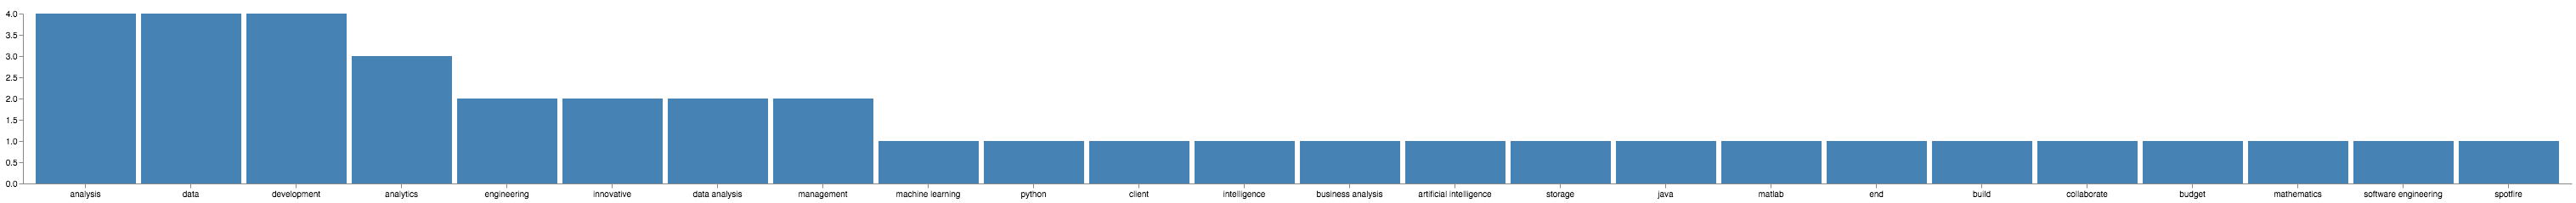

In [87]:
#### Data Scientist
makeVegeSkillFoundPlot(test[0])

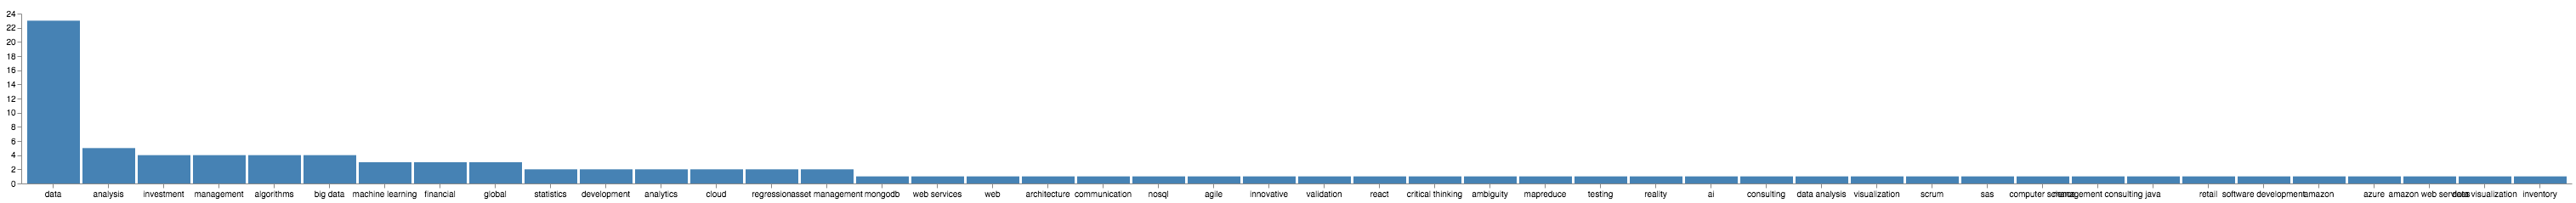

In [88]:
#### Data Scientist
makeVegeSkillFoundPlot(test[1])

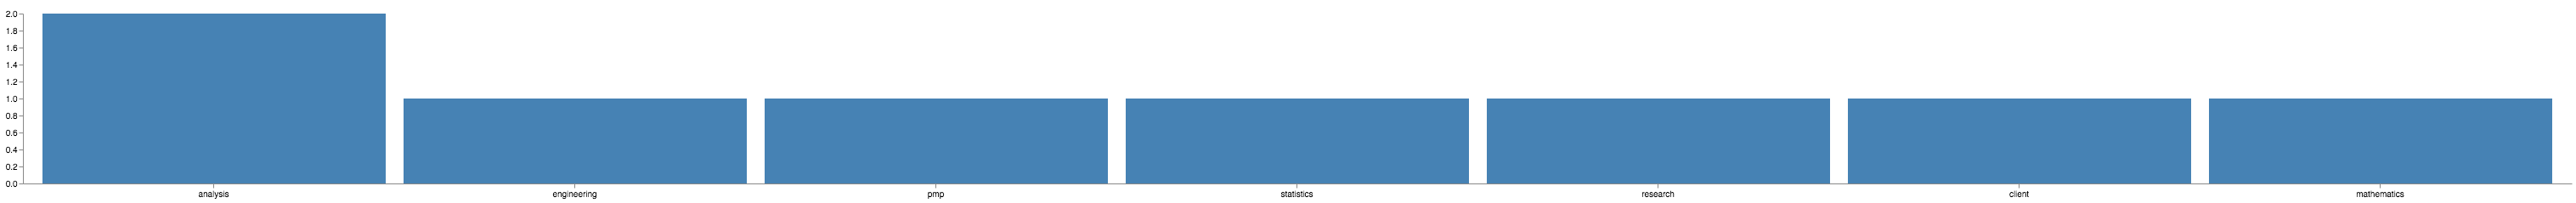

In [89]:
#### Data Scientist
makeVegeSkillFoundPlot(test[2])

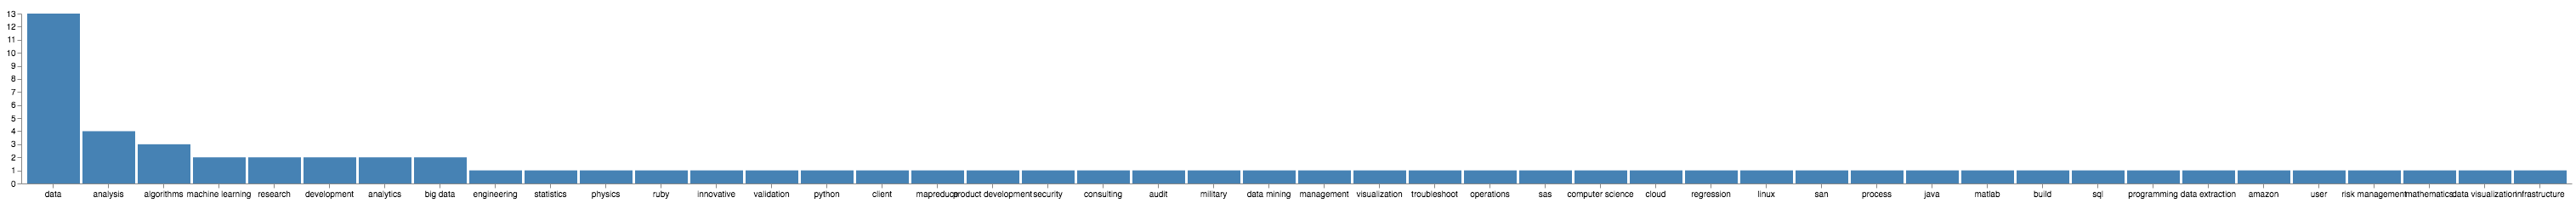

In [95]:
#### Data Scientist
makeVegeSkillFoundPlot(test[6])

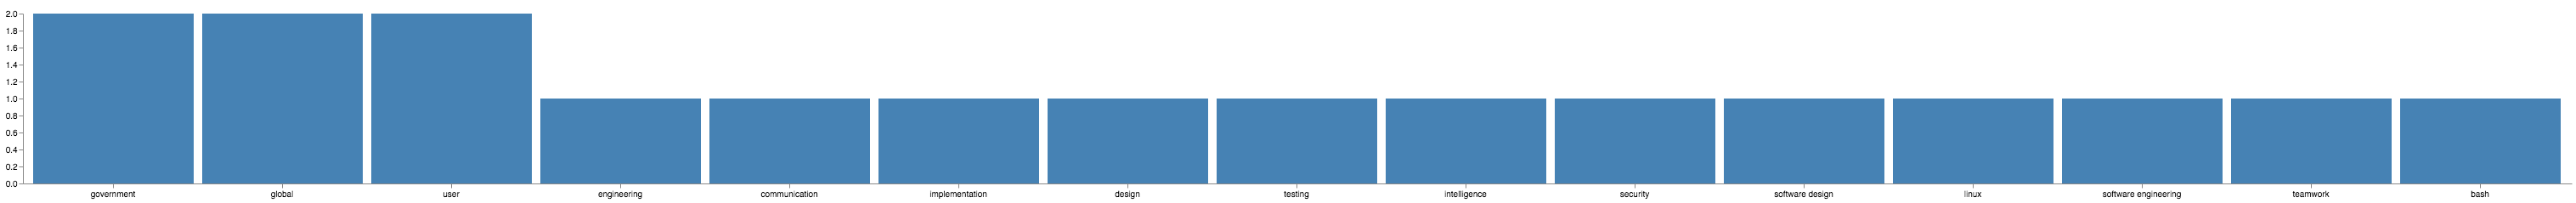

In [91]:
#### Software Engineer
makeVegeSkillFoundPlot(test[11])

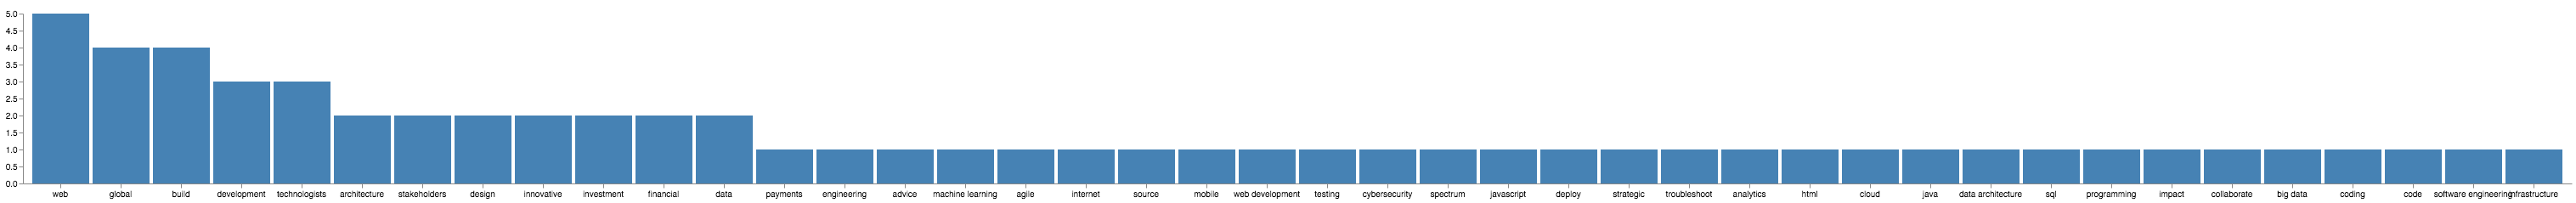

In [92]:
#### Software Engineer
makeVegeSkillFoundPlot(test[12])

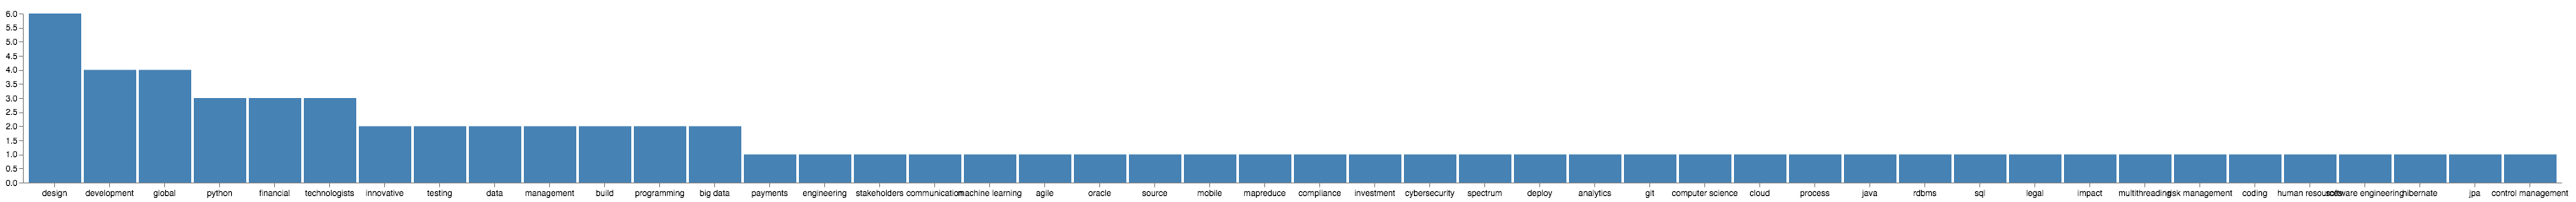

In [93]:
#### Software Engineer
makeVegeSkillFoundPlot(test[13])

### Observations from just looking at the skill counts:
Some obvious trends are seen just looking at the most common skills tagged, which makes it seem likely a simple model and small dataset will be enough to make ok predictions for a toy model.

If you were going to make significant decisions based on this, say pick which resumes to read, you'd want a much much better model. I <b>hope</b> systems that actually do this use a very sophisticatd model.

# To be continued....
## To make all of this notebook visiable on github, I'm splitting it in two. You can find the next bit <a href="">here</a> where we'll get into vectorization and machine-learning.